In [193]:
from PIL import Image as Pimage
import cv2 as cv
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchvision.transforms as ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

In [194]:
device = "cuda"

class CustomDataLoader(Dataset):

    def __init__(self, img_dir, transform=None, target_transform=None):

        self.label_num = {}
        self.num_label = {}
        self.img_dir = img_dir
        self.from_image_to_label(img_dir)
        self.img_labels = pd.read_csv("dataset.csv")
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Pimage.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
       
        return image, label
    
    def __len__(self):
        return len(self.img_labels)

    def from_image_to_label(self, image_dir):

        num = 0
        with open("dataset.csv", "w") as f:
            for img_name in os.listdir(image_dir):
                img_label = img_name.split(("-"))[0]

                if img_label not in self.label_num.keys():
                    self.label_num[img_label] = num
                    self.num_label[num] = img_label
                    num = num + 1
                
                f.write(img_name + "," + str(self.label_num[img_label]) + "\n")
        f.close()
        
    
    def label_to_num(self, label):
        return self.label_num[label]
    
    def num_to_label(self, idx):
        return self.num_to_label[idx]



In [195]:
img_dir = "../data/"
t=ToTensor.Compose([ToTensor.ToTensor(), ToTensor.Resize([1200, 1200])])
image_dataset = CustomDataLoader(img_dir,transform=t)
train_len = int(image_dataset.__len__()*0.8)
test_len = image_dataset.__len__() - train_len
train_set, test_set = data.random_split(image_dataset, [train_len, test_len])

train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=4, shuffle=True)


Feature batch shape: torch.Size([4, 3, 1200, 1200])
Labels batch shape: tensor([2, 0, 0, 1])


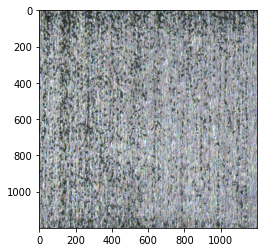

Label: 2


In [196]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0),cmap='gray',vmin=0,vmax=255)
plt.show()
print(f"Label: {label}")

In [197]:
class customNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 20, 64, stride=4),
                                   nn.ReLU(),
                                   nn.Conv2d(20,64,16, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   nn.Flatten())

        self.fullc = nn.Sequential(nn.Linear(287296,128),
                                   nn.Linear(128, 3))    

    def forward(self, x):
        x = self.conv1(x)
        x = self.fullc(x)
        return x


In [198]:

model = customNet().to(device)


In [199]:
criterion = nn.CrossEntropyLoss()
adam = optim.Adam(params = model.parameters(), lr=0.0001)
step_lr = 0.99
#adam_f = optim.lr_scheduler.ExponentialLR(optimizer=adam, gamma=step_lr)

In [202]:
device = "cuda"
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        if(device =='cuda'):
            inputs = inputs.cuda()
            labels = labels.cuda()
        adam.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        adam.step()
        running_loss += loss.item()
        if i % 5 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
            running_loss = 0.0
print('Finished Training')


[1,     1] loss: 0.00052
[2,     1] loss: 0.00054
[3,     1] loss: 0.00049
[4,     1] loss: 0.00058
[5,     1] loss: 0.00058
[6,     1] loss: 0.00053
[7,     1] loss: 0.00057
[8,     1] loss: 0.00054
[9,     1] loss: 0.00053
[10,     1] loss: 0.00054
[11,     1] loss: 0.00055
[12,     1] loss: 0.00052
[13,     1] loss: 0.00050
[14,     1] loss: 0.00047
[15,     1] loss: 0.00054
[16,     1] loss: 0.00054
[17,     1] loss: 0.00059
[18,     1] loss: 0.00058
[19,     1] loss: 0.00053
[20,     1] loss: 0.00051
[21,     1] loss: 0.00050
[22,     1] loss: 0.00054
[23,     1] loss: 0.00052
[24,     1] loss: 0.00051
[25,     1] loss: 0.00053
[26,     1] loss: 0.00055
[27,     1] loss: 0.00055
[28,     1] loss: 0.00058
[29,     1] loss: 0.00055
[30,     1] loss: 0.00054
[31,     1] loss: 0.00060
[32,     1] loss: 0.00056
[33,     1] loss: 0.00049
[34,     1] loss: 0.00059
[35,     1] loss: 0.00054
[36,     1] loss: 0.00054
[37,     1] loss: 0.00049
[38,     1] loss: 0.00054
[39,     1] loss: 0.0

KeyboardInterrupt: 